# Explorando datos

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


df = pd.read_csv("TelecomX_DatosLimpios.csv")
print("✅ Datos cargados:", df.shape)


target = "BajaCliente" if "BajaCliente" in df.columns else "Churn"

def normalize_target(s: pd.Series) -> pd.Series:
    # si ya es 0/1 puros
    if pd.api.types.is_integer_dtype(s) or pd.api.types.is_bool_dtype(s):
        return s.astype("Int64")


    t = s.astype(str).str.strip().str.lower()
    mapping = {
        "yes": 1, "sí": 1, "si": 1, "true": 1, "1": 1,
        "no": 0, "false": 0, "0": 0
    }
    y = t.map(mapping)


    y = y.fillna(pd.to_numeric(t, errors="coerce"))

    return y.astype("Int64")

y = normalize_target(df[target])


na_count = y.isna().sum()
if na_count > 0:
    print(f"⚠️  Se eliminarán {na_count} filas con objetivo desconocido (p.ej. 'Unknown').")
    keep = y.notna()
    df = df.loc[keep].reset_index(drop=True)
    y = y.loc[keep].reset_index(drop=True)


y = y.astype(int)


drop_cols = [target, "ID_Cliente", "customerID"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])


cat_vars = X.select_dtypes(include=["object"]).columns.tolist()
num_vars = X.select_dtypes(include=["int64","float64"]).columns.tolist()

print("📦 Categóricas:", cat_vars)
print("📐 Numéricas:", num_vars)


X_encoded = pd.get_dummies(X, columns=cat_vars, drop_first=True)


scaler = StandardScaler()
if len(num_vars) > 0:
    X_encoded[num_vars] = scaler.fit_transform(X_encoded[num_vars])

print("✅ Datos listos para modelado:", X_encoded.shape)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.30, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


✅ Datos cargados: (7267, 22)
⚠️  Se eliminarán 224 filas con objetivo desconocido (p.ej. 'Unknown').
📦 Categóricas: ['Genero', 'TipoInternet', 'TipoContrato', 'MetodoPago']
📐 Numéricas: ['AdultoMayor', 'TienePareja', 'TieneDependientes', 'Meses_Permanencia', 'ServicioTelefonico', 'LineasMultiples', 'SeguridadOnline', 'RespaldoOnline', 'ProteccionDispositivo', 'SoporteTecnico', 'StreamingTV', 'StreamingPeliculas', 'FacturaSinPapel', 'CargoMensual', 'CargoTotal', 'CargoDiario']
✅ Datos listos para modelado: (7043, 24)
Train: (4930, 24) Test: (2113, 24)


# Eliminación de Columnas Irrelevantes

In [16]:
irrelevantes = [c for c in ["ID_Cliente", "customerID"] if c in X_encoded.columns]

if irrelevantes:
    print("🔎 Columnas irrelevantes encontradas:", irrelevantes)
    X_encoded = X_encoded.drop(columns=irrelevantes)
else:
    print("✅ No se encontraron columnas irrelevantes en X_encoded")

print("📐 Dimensiones finales de X_encoded:", X_encoded.shape)


✅ No se encontraron columnas irrelevantes en X_encoded
📐 Dimensiones finales de X_encoded: (7043, 24)


# Encoding

In [17]:
cat_vars = X.select_dtypes(include=["object"]).columns.tolist()

if cat_vars:
    print("🔎 Variables categóricas detectadas:", cat_vars)

    X_encoded = pd.get_dummies(X, columns=cat_vars, drop_first=True)
    print("✅ One-Hot Encoding aplicado")
else:
    print("✅ No hay variables categóricas pendientes de codificar")

print("📐 Dimensiones de X_encoded después del encoding:", X_encoded.shape)
display(X_encoded.head())


🔎 Variables categóricas detectadas: ['Genero', 'TipoInternet', 'TipoContrato', 'MetodoPago']
✅ One-Hot Encoding aplicado
📐 Dimensiones de X_encoded después del encoding: (7043, 24)


,AdultoMayor,TienePareja,TieneDependientes,Meses_Permanencia,ServicioTelefonico,LineasMultiples,SeguridadOnline,RespaldoOnline,ProteccionDispositivo,SoporteTecnico,...,CargoTotal,CargoDiario,Genero_Male,TipoInternet_Fiber optic,TipoInternet_No,TipoContrato_One year,TipoContrato_Two year,MetodoPago_Credit card (automatic),MetodoPago_Electronic check,MetodoPago_Mailed check
0,0,1.0,1.0,9,1.0,0.0,0.0,1.0,0.0,1.0,...,593.30,2.19,False,False,False,True,False,False,False,True
1,0,0.0,0.0,9,1.0,1.0,0.0,0.0,0.0,0.0,...,542.40,2.00,True,False,False,False,False,False,False,True
2,0,0.0,0.0,4,1.0,0.0,0.0,0.0,1.0,0.0,...,280.85,2.46,True,True,False,False,False,False,True,False
3,1,1.0,0.0,13,1.0,0.0,0.0,1.0,1.0,0.0,...,1237.85,3.27,True,True,False,False,False,False,True,False
4,1,1.0,0.0,3,1.0,0.0,0.0,0.0,0.0,1.0,...,267.40,2.80,False,True,False,False,False,False,False,True


# Verificación de la Proporción de Cancelación (Churn)

📊 Distribución de la variable objetivo (Churn):
No cancelaron: 5174 clientes (73.46%)
Cancelaron: 1869 clientes (26.54%)


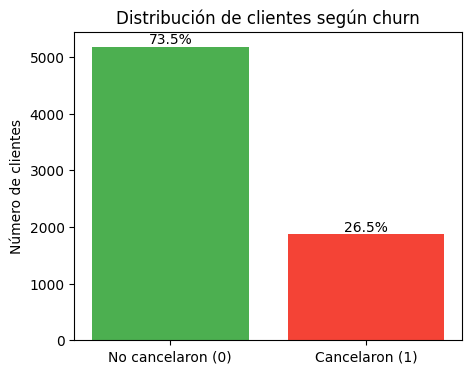

In [18]:
import matplotlib.pyplot as plt


churn_counts = y.value_counts().sort_index()  # 0 = No, 1 = Sí
churn_percent = y.value_counts(normalize=True).sort_index() * 100

print("📊 Distribución de la variable objetivo (Churn):")
for label, count, pct in zip(churn_counts.index, churn_counts, churn_percent):
    estado = "No cancelaron" if label == 0 else "Cancelaron"
    print(f"{estado}: {count} clientes ({pct:.2f}%)")


plt.figure(figsize=(5,4))
bars = plt.bar(["No cancelaron (0)", "Cancelaron (1)"], churn_counts.values, color=["#4CAF50","#F44336"])
plt.title("Distribución de clientes según churn")
plt.ylabel("Número de clientes")


for bar, pct in zip(bars, churn_percent.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{pct:.1f}%",
             ha="center", va="bottom", fontsize=10)

plt.show()


In [19]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Balanceo de Clases

In [20]:
from imblearn.over_sampling import SMOTE

print("Distribución original de clases:")
print(y_train.value_counts(normalize=True) * 100)


smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("\n✅ Distribución tras aplicar SMOTE:")
print(y_train_bal.value_counts(normalize=True) * 100)


Distribución original de clases:
BajaCliente
0    73.46856
1    26.53144
Name: proportion, dtype: float64

✅ Distribución tras aplicar SMOTE:
BajaCliente
0    50.0
1    50.0
Name: proportion, dtype: float64


# Normalización o Estandarización

In [21]:
from sklearn.preprocessing import StandardScaler


print("📊 Estadísticas de las primeras variables numéricas (antes de escalar):")
display(X_train.iloc[:,:5].describe())


scaler = StandardScaler()


X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

num_vars = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()

if num_vars:
    X_train_scaled[num_vars] = scaler.fit_transform(X_train[num_vars])
    X_test_scaled[num_vars] = scaler.transform(X_test[num_vars])
    print("✅ Variables numéricas escaladas correctamente")
else:
    print("ℹ️ No se encontraron variables numéricas para escalar")


📊 Estadísticas de las primeras variables numéricas (antes de escalar):


,AdultoMayor,TienePareja,TieneDependientes,Meses_Permanencia,ServicioTelefonico
count,4930.000000,4930.000000,4930.000000,4930.000000,4930.000000
mean,-0.003513,-0.004608,0.007541,0.006321,0.022216
std,0.996870,0.999934,1.003367,1.001518,0.969083
min,-0.439916,-0.966622,-0.654012,-1.318165,-3.054010
25%,-0.439916,-0.966622,-0.654012,-0.951682,0.327438
50%,-0.439916,-0.966622,-0.654012,-0.137274,0.327438
75%,-0.439916,1.034530,1.529024,0.962175,0.327438
max,2.273159,1.034530,1.529024,1.613701,0.327438


✅ Variables numéricas escaladas correctamente


# Análisis de Correlación

📊 Correlación de variables con la evasión (Churn):


,BajaCliente
BajaCliente,1.000000
MetodoPago_Electronic check,0.306069
TipoInternet_Fiber optic,0.300916
FacturaSinPapel,0.198066
CargoDiario,0.184705
CargoMensual,0.184680
AdultoMayor,0.150819
StreamingTV,0.062386
StreamingPeliculas,0.051363
LineasMultiples,0.033495


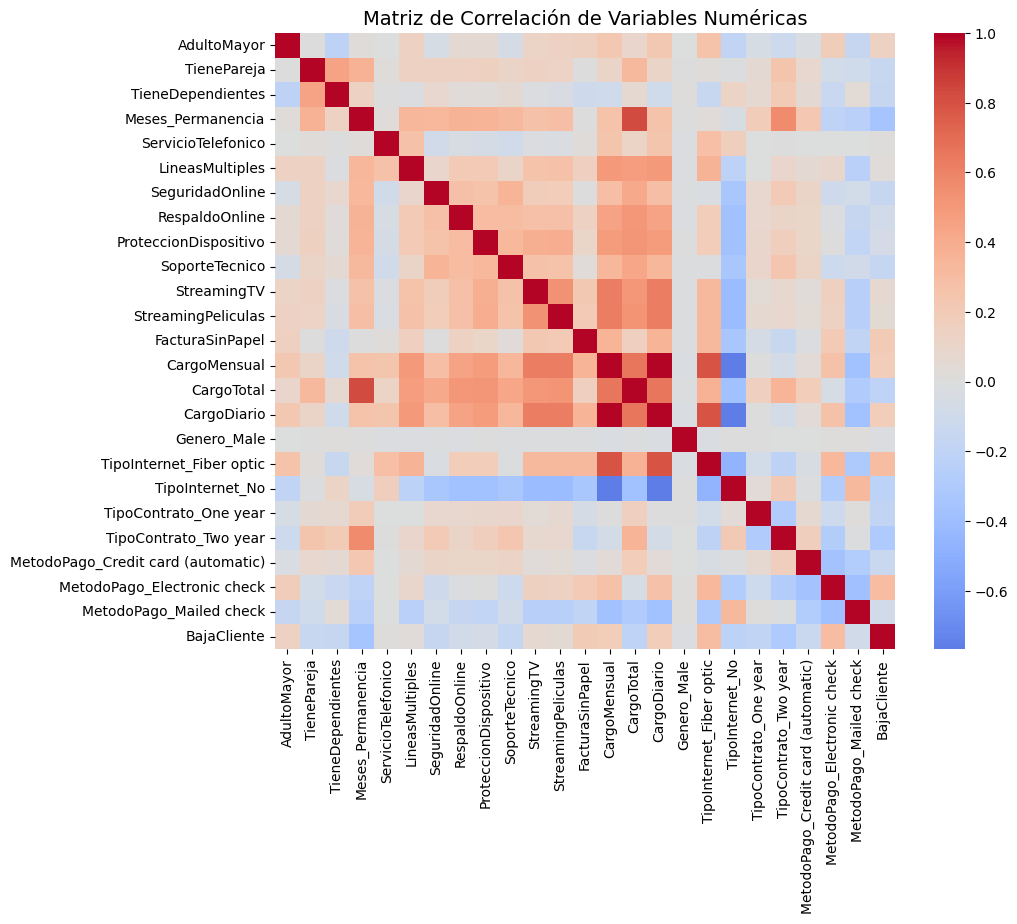

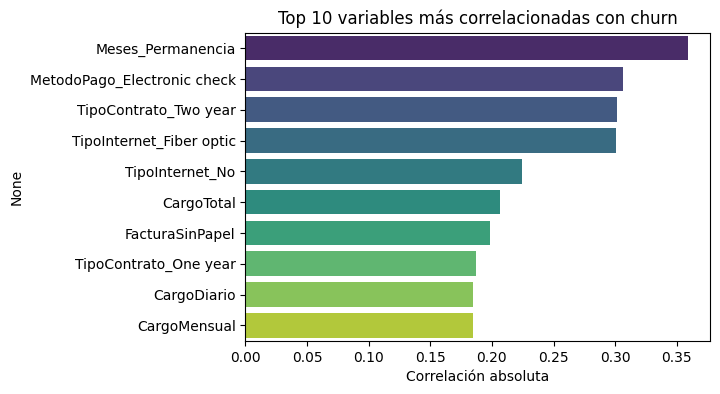

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


df_corr = X_train_scaled.copy()
df_corr[target] = y_train.values


corr_matrix = df_corr.corr()


corr_target = corr_matrix[target].sort_values(ascending=False)

print("📊 Correlación de variables con la evasión (Churn):")
display(corr_target)


plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Matriz de Correlación de Variables Numéricas", fontsize=14)
plt.show()


top_corr = corr_target.drop(target).abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(6,4))
sns.barplot(x=top_corr.values, y=top_corr.index, palette="viridis")
plt.title("Top 10 variables más correlacionadas con churn")
plt.xlabel("Correlación absoluta")
plt.show()


# Análisis Dirigido

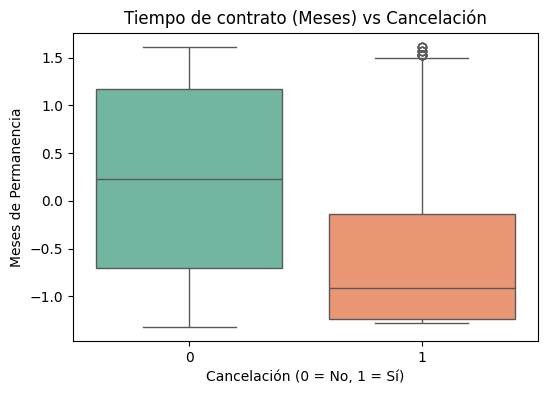

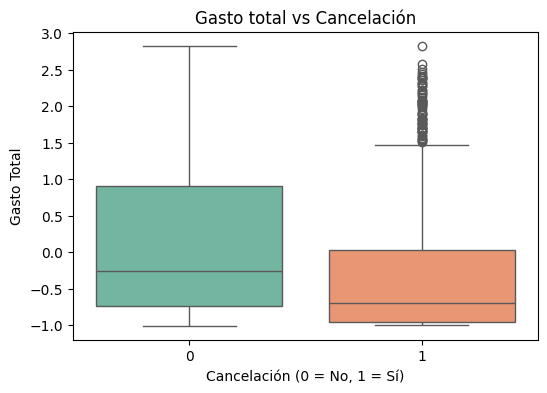

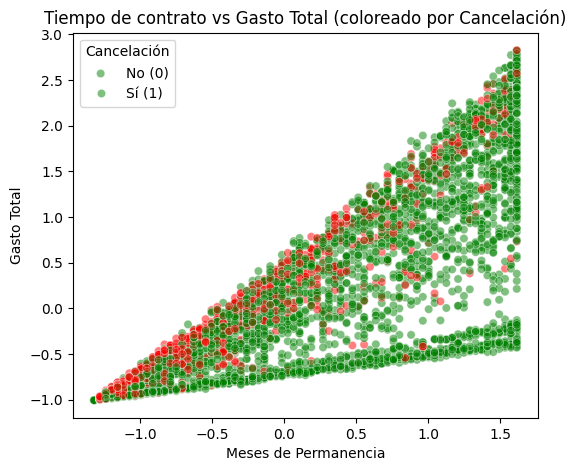

In [23]:
churn_col = target  # ya definido en pasos anteriores

# 1) Tiempo de contrato × Cancelación
if "Meses_Permanencia" in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=y_train, y=X_train["Meses_Permanencia"], palette="Set2")
    plt.title("Tiempo de contrato (Meses) vs Cancelación")
    plt.xlabel("Cancelación (0 = No, 1 = Sí)")
    plt.ylabel("Meses de Permanencia")
    plt.show()

# 2) Gasto total × Cancelación
cargo_col = None
for c in ["CargoTotal","account_Charges_Total"]:
    if c in df.columns:
        cargo_col = c
        break

if cargo_col:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=y_train, y=X_train[cargo_col], palette="Set2")
    plt.title("Gasto total vs Cancelación")
    plt.xlabel("Cancelación (0 = No, 1 = Sí)")
    plt.ylabel("Gasto Total")
    plt.show()

# 3) Scatter plot opcional (Tiempo de contrato vs Gasto total, coloreado por Churn)
if "Meses_Permanencia" in df.columns and cargo_col:
    plt.figure(figsize=(6,5))
    sns.scatterplot(
        x=X_train["Meses_Permanencia"],
        y=X_train[cargo_col],
        hue=y_train,
        palette={0:"green",1:"red"},
        alpha=0.5
    )
    plt.title("Tiempo de contrato vs Gasto Total (coloreado por Cancelación)")
    plt.xlabel("Meses de Permanencia")
    plt.ylabel("Gasto Total")
    plt.legend(title="Cancelación", labels=["No (0)","Sí (1)"])
    plt.show()


# Separación de Datos

In [24]:

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("✅ División completada")
print("Tamaño de entrenamiento:", X_train.shape, " - ", y_train.shape)
print("Tamaño de prueba:", X_test.shape, " - ", y_test.shape)
print("\nDistribución en entrenamiento:")
print(y_train.value_counts(normalize=True) * 100)
print("\nDistribución en prueba:")
print(y_test.value_counts(normalize=True) * 100)


✅ División completada
Tamaño de entrenamiento: (4930, 24)  -  (4930,)
Tamaño de prueba: (2113, 24)  -  (2113,)

Distribución en entrenamiento:
BajaCliente
0    73.46856
1    26.53144
Name: proportion, dtype: float64

Distribución en prueba:
BajaCliente
0    73.450071
1    26.549929
Name: proportion, dtype: float64


# Creación de Modelos

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

print("✅ Modelo de Regresión Logística entrenado")


rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
rf_clf.fit(X_train, y_train)

print("✅ Modelo de Random Forest entrenado")


✅ Modelo de Regresión Logística entrenado
✅ Modelo de Random Forest entrenado


# Evaluación de los Modelos


📊 Evaluación del modelo: Regresión Logística
Accuracy : 0.7979
Precisión: 0.6402
Recall   : 0.5455
F1-score : 0.5890
Accuracy Train: 0.8105 | Accuracy Test: 0.7979


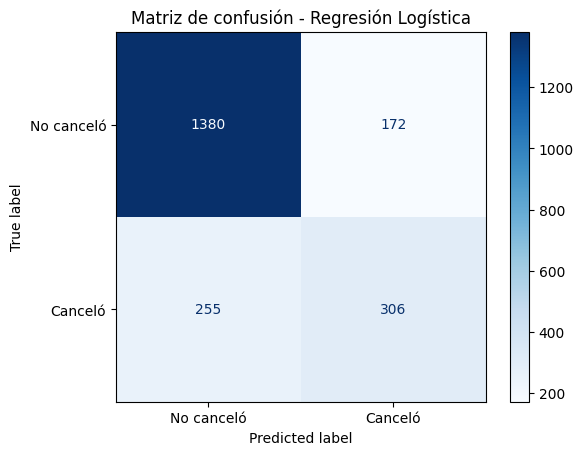


📊 Evaluación del modelo: Random Forest
Accuracy : 0.7814
Precisión: 0.6122
Recall   : 0.4813
F1-score : 0.5389
Accuracy Train: 0.9978 | Accuracy Test: 0.7814


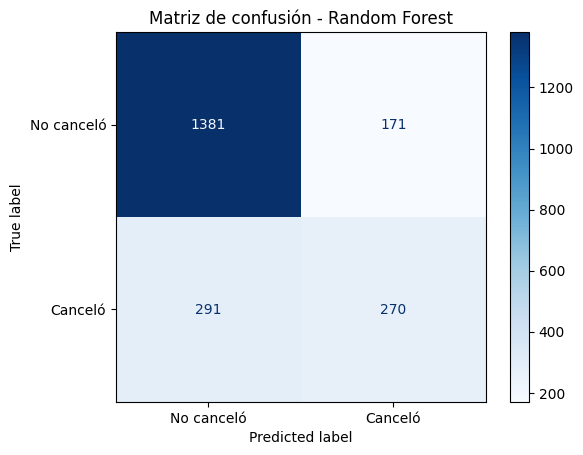

,Modelo,Accuracy,Precisión,Recall,F1-score,Acc_Train
0,Regresión Logística,0.797918,0.640167,0.545455,0.589028,0.810548
1,Random Forest,0.781354,0.612245,0.481283,0.538922,0.997769


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


def evaluar_modelo(nombre, modelo, Xtr, Xts, ytr, yts):

    y_pred_train = modelo.predict(Xtr)
    y_pred_test = modelo.predict(Xts)


    acc = accuracy_score(yts, y_pred_test)
    prec = precision_score(yts, y_pred_test)
    rec = recall_score(yts, y_pred_test)
    f1 = f1_score(yts, y_pred_test)

    print(f"\n📊 Evaluación del modelo: {nombre}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precisión: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")


    acc_train = accuracy_score(ytr, y_pred_train)
    print(f"Accuracy Train: {acc_train:.4f} | Accuracy Test: {acc:.4f}")


    cm = confusion_matrix(yts, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No canceló","Canceló"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Matriz de confusión - {nombre}")
    plt.show()

    return {
        "Modelo": nombre,
        "Accuracy": acc,
        "Precisión": prec,
        "Recall": rec,
        "F1-score": f1,
        "Acc_Train": acc_train
    }

# Evaluar Regresión Logística
result_log = evaluar_modelo("Regresión Logística", log_reg, X_train_scaled, X_test_scaled, y_train, y_test)

# Evaluar Random Forest
result_rf = evaluar_modelo("Random Forest", rf_clf, X_train, X_test, y_train, y_test)

# Tabla comparativa
import pandas as pd
resultados = pd.DataFrame([result_log, result_rf])
display(resultados)


# Análisis de la Importancia de las Variables

🔎 Top 10 coeficientes (Regresión Logística):


,0
Meses_Permanencia,-1.466009
TipoContrato_Two year,-1.275694
TipoContrato_One year,-0.726666
TipoInternet_No,-0.724780
CargoTotal,0.708055
TipoInternet_Fiber optic,0.686764
MetodoPago_Electronic check,0.358032
FacturaSinPapel,0.203675
SoporteTecnico,-0.199189
ServicioTelefonico,-0.183361


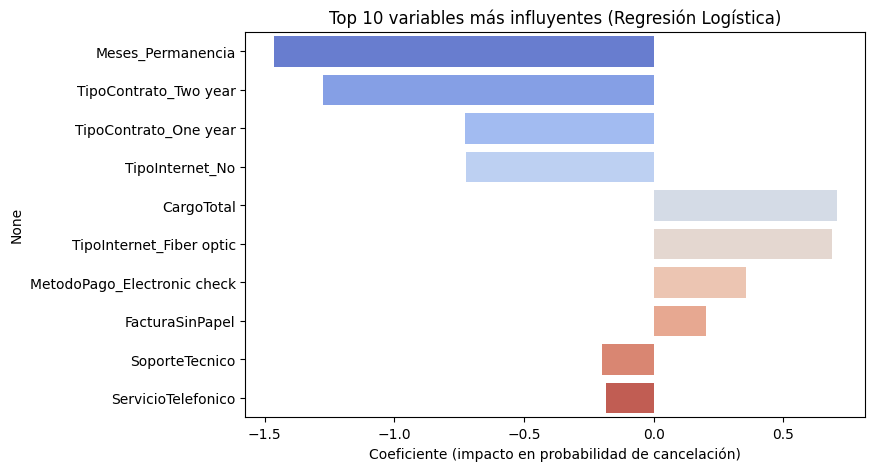

🔎 Top 10 variables más importantes (Random Forest):


,0
CargoTotal,0.156490
Meses_Permanencia,0.155505
CargoMensual,0.131839
CargoDiario,0.112947
TipoContrato_Two year,0.062254
TipoInternet_Fiber optic,0.041955
MetodoPago_Electronic check,0.035781
TipoContrato_One year,0.032563
FacturaSinPapel,0.024423
Genero_Male,0.023566


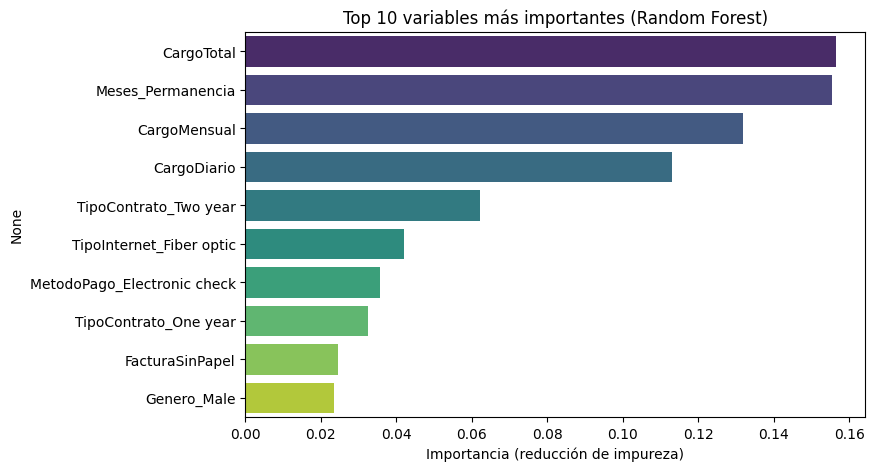

In [27]:
import numpy as np
import seaborn as sns


coef_log = pd.Series(log_reg.coef_[0], index=X_train_scaled.columns)
coef_log = coef_log.sort_values(key=abs, ascending=False)

print("🔎 Top 10 coeficientes (Regresión Logística):")
display(coef_log.head(10))

plt.figure(figsize=(8,5))
sns.barplot(x=coef_log.head(10).values, y=coef_log.head(10).index, palette="coolwarm")
plt.title("Top 10 variables más influyentes (Regresión Logística)")
plt.xlabel("Coeficiente (impacto en probabilidad de cancelación)")
plt.show()


importancias_rf = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
importancias_rf = importancias_rf.sort_values(ascending=False)

print("🔎 Top 10 variables más importantes (Random Forest):")
display(importancias_rf.head(10))

plt.figure(figsize=(8,5))
sns.barplot(x=importancias_rf.head(10).values, y=importancias_rf.head(10).index, palette="viridis")
plt.title("Top 10 variables más importantes (Random Forest)")
plt.xlabel("Importancia (reducción de impureza)")
plt.show()


# Conclusión

## Factores Clave en la Cancelación
- **Tiempo de permanencia (Meses_Permanencia)**: mayor permanencia reduce fuertemente la probabilidad de cancelación.  
- **Tipo de contrato**: los contratos de **dos años** y de **un año** disminuyen el churn en comparación con los contratos mensuales.  
- **Tipo de internet**: los clientes con **Fibra Óptica** presentaron mayor propensión a cancelar, mientras que quienes no tienen internet tienen menor riesgo.  
- **Cargos Totales (CargoTotal)**: valores acumulados altos se asocian a mayor evasión.  
- **Método de pago – Electronic Check**: más relacionado con cancelaciones, probablemente por su menor estabilidad en pagos.  
- **Otros factores protectores**: tener **soporte técnico** y **servicio telefónico** reduce la probabilidad de baja.

## Comparación de Modelos
- **Regresión Logística** tuvo mejor desempeño en test:
  - Accuracy: **0.798**
  - Recall: **0.545**
  - F1-score: **0.589**
- **Random Forest** mostró sobreajuste (*overfitting*):
  - Accuracy Entrenamiento ≈ **0.998**
  - Accuracy Prueba ≈ **0.781**
- Esto indica que la **Regresión Logística generaliza mejor**, mientras que Random Forest confirma la importancia de variables clave.

## Estrategias de Retención
1. **Fomentar contratos largos**: incentivar a clientes con contrato mensual a migrar a planes de 1 o 2 años con beneficios.  
2. **Gestionar clientes de Fibra Óptica**: mejorar la calidad de servicio y soporte técnico en este segmento crítico.  
3. **Alertas para clientes con cargos altos**: ofrecer planes más flexibles o escalonados para reducir la percepción de costo elevado.  
4. **Optimizar métodos de pago**: promover pagos automáticos o recurrentes en lugar de *Electronic Check*.  
5. **Reforzar soporte técnico**: resaltar este servicio como diferenciador que contribuye a la permanencia.  

---

 El análisis confirma que la **permanencia, el tipo de contrato, el tipo de internet, los cargos acumulados y el método de pago** son los principales factores que influyen en la cancelación.  
Enfocarse en estos aspectos permitirá **reducir la tasa de churn y mejorar la retención de clientes**.
